# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

import os, sys, re, gc, joblib
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scipy.sparse as sp

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap

import seaborn as sn

import anndata
import scanpy as sc
import sctk as sk


rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
np.set_printoptions(linewidth=180)
sc.settings.verbosity = 1
sk.set_figsize((4, 4))
expr_cmap = sk.expression_colormap()

# Load data

In [3]:
pooled_ad = sc.read("h5ad/pooled_fetal_organoid.count_with_annot.h5ad")

In [4]:
pooled_ad

AnnData object with n_obs × n_vars = 310368 × 46794
    obs: 'dataset', 'donor', 'pcw', 'day', 'sample_id', 'fetal_annot', 'organoid_annot', 'pooled_annot', 'chemistry', 'gender', 'sorting'
    var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'

In [5]:
pooled_ad.X.data

array([5., 1., 1., ..., 1., 1., 1.], dtype=float32)

In [6]:
pooled_ad.obs.pooled_annot.cat.categories.tolist()

['fetal_ASDC',
 'fetal_Adipocytes',
 'fetal_Arterial',
 'fetal_B cell',
 'fetal_Basal',
 'fetal_CD4 T cell',
 'fetal_CD8 T cell',
 'fetal_Capillary (venular tip)',
 'fetal_Capillary/postcapillary venule',
 'fetal_Companion layer',
 'fetal_Cuticle/cortex',
 'fetal_DC1',
 'fetal_DC2',
 'fetal_Dermal condensate',
 'fetal_Dermal papillia',
 'fetal_Early LE',
 'fetal_Early endothelial cell',
 'fetal_Early erythroid',
 'fetal_Early erythroid (embryonic)',
 'fetal_Early myocytes',
 'fetal_Eo/baso/mast cell progenitor',
 'fetal_Erythroid (embryonic)',
 'fetal_Erythroid (fetal)',
 'fetal_FRZB+ early fibroblast',
 'fetal_HOXC5+ early fibroblast',
 'fetal_HSC',
 'fetal_ILC2',
 'fetal_ILC3',
 'fetal_Immature basal',
 'fetal_Immature suprabasal',
 'fetal_Inflammatory DC',
 'fetal_Innate T type1',
 'fetal_Innate T type3',
 'fetal_Inner root sheath',
 'fetal_Iron-recycling macrophage',
 'fetal_LC',
 'fetal_LE',
 'fetal_LMCD1+ mural cell',
 'fetal_LTi',
 'fetal_LYVE1++ macrophage',
 'fetal_Lymphoid pr

# Process

## Subset, split, normalise, etc

In [7]:
pooled_ad.obs.pooled_annot.cat.rename_categories(
    {"organoid_POSTN+ fibroblast": "organoid_WNT2+ fibroblast"}, inplace=True
)

In [8]:
k_included = pooled_ad.obs.pooled_annot.isin(
    [
        "fetal_Basal",
        "fetal_Companion layer",
        "fetal_Cuticle/cortex",
        "fetal_Immature basal",
        "fetal_Immature suprabasal",
        "fetal_Inner root sheath",
        "fetal_Matrix/placode",
        "fetal_Outer root sheath",
        "fetal_Periderm",
        "fetal_POSTN+ basal",
        "fetal_Suprabasal IFE",
        "fetal_FRZB+ early fibroblast",
        "fetal_HOXC5+ early fibroblast",
        "fetal_WNT2+ fibroblast",
        "fetal_PEAR1+ fibroblast",
        "fetal_Pre-dermal condensate",
        "fetal_Dermal condensate",
        "fetal_Dermal papillia",
        "organoid_Basal",
        "organoid_Companion layer",
        "organoid_Cuticle/cortex",
        "organoid_Immature basal",
        "organoid_Immature suprabasal",
        "organoid_Inner root sheath",
        "organoid_Matrix/placode",
        "organoid_Outer root sheath",
        "organoid_Periderm",
        "organoid_POSTN+ basal",
        "organoid_Suprabasal IFE",
        "organoid_FRZB+ early fibroblast",
        "organoid_HOXC5+ early fibroblast",
        "organoid_WNT2+ fibroblast",
        "organoid_PEAR1+ fibroblast",
        "organoid_Pre-dermal condensate",
        "organoid_Dermal condensate",
        "organoid_Dermal papillia",
    ]
)

In [9]:
ad1 = pooled_ad[k_included]

In [10]:
ads = sk.split_by_group(ad1, groupby="dataset")

In [11]:
ads

{'fetal': AnnData object with n_obs × n_vars = 93891 × 46794
     obs: 'dataset', 'donor', 'pcw', 'day', 'sample_id', 'fetal_annot', 'organoid_annot', 'pooled_annot', 'chemistry', 'gender', 'sorting'
     var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells',
 'organoid': AnnData object with n_obs × n_vars = 105303 × 46794
     obs: 'dataset', 'donor', 'pcw', 'day', 'sample_id', 'fetal_annot', 'organoid_annot', 'pooled_annot', 'chemistry', 'gender', 'sorting'
     var: 'mito', 'ribo', 'hb', 'n_counts', 'n_cells'}

In [12]:
for name, ad in ads.items():
    sc.pp.filter_genes(ad, min_counts=1)
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

In [13]:
ads["fetal"].X.data

array([0.43932745, 0.43932745, 0.9764408 , ..., 1.5827801 , 1.5827801 , 1.5827801 ], dtype=float32)

## Extract and prepare data to plot

In [14]:
fetal_genes = [
    "KRT5",
    "KRT14",
    "KLHL24",
    "DST",
    "EXPH5",
    "PLEC",
    "CD151",
    "COL17A1",
    "ITGA3",
    "ITGA6",
    "ITGB4",
    "LAMA3",
    "LAMB3",
    "LAMC2",
    "COL7A1",
    "FERMT1",
]
organoid_genes = fetal_genes

In [38]:
fetal_df = sk.summarise_expression_by_group(ads["fetal"], groupby="pooled_annot", genes=fetal_genes)
fetal_df["group"] = fetal_df["group"].astype(str).str.replace("fetal_", "")
fetal_df["dataset"] = "fetal"

In [39]:
fetal_df

,gene,group,frac,avg,dataset
0,CD151,Basal,0.835583,0.945127,fetal
1,CD151,Companion layer,0.888889,1.068020,fetal
2,CD151,Cuticle/cortex,0.809524,0.996445,fetal
3,CD151,Dermal condensate,0.315380,0.366148,fetal
4,CD151,Dermal papillia,0.353025,0.495246,fetal
...,...,...,...,...,...
283,PLEC,POSTN+ basal,0.434783,0.470148,fetal
284,PLEC,Periderm,0.267974,0.221562,fetal
285,PLEC,Pre-dermal condensate,0.104603,0.093817,fetal
286,PLEC,Suprabasal IFE,0.133333,0.147472,fetal


In [40]:
organoid_df = sk.summarise_expression_by_group(
    ads["organoid"], groupby="pooled_annot", genes=fetal_genes
)
organoid_df["group"] = organoid_df["group"].astype(str).str.replace("organoid_", "")
organoid_df["dataset"] = "organoid"

In [41]:
organoid_df

,gene,group,frac,avg,dataset
0,CD151,Basal,0.712405,0.852125,organoid
1,CD151,Companion layer,0.705293,0.704219,organoid
2,CD151,Cuticle/cortex,0.856507,0.826898,organoid
3,CD151,Dermal condensate,0.486087,0.484598,organoid
4,CD151,Dermal papillia,0.377051,0.475307,organoid
...,...,...,...,...,...
267,PLEC,POSTN+ basal,0.221971,0.204220,organoid
268,PLEC,WNT2+ fibroblast,0.143161,0.127338,organoid
269,PLEC,Periderm,0.316956,0.233664,organoid
270,PLEC,Pre-dermal condensate,0.141010,0.120699,organoid


In [42]:
df = pd.concat([fetal_df, organoid_df])

In [43]:
df

,gene,group,frac,avg,dataset
0,CD151,Basal,0.835583,0.945127,fetal
1,CD151,Companion layer,0.888889,1.068020,fetal
2,CD151,Cuticle/cortex,0.809524,0.996445,fetal
3,CD151,Dermal condensate,0.315380,0.366148,fetal
4,CD151,Dermal papillia,0.353025,0.495246,fetal
...,...,...,...,...,...
267,PLEC,POSTN+ basal,0.221971,0.204220,organoid
268,PLEC,WNT2+ fibroblast,0.143161,0.127338,organoid
269,PLEC,Periderm,0.316956,0.233664,organoid
270,PLEC,Pre-dermal condensate,0.141010,0.120699,organoid


In [44]:
df["gene2"] = df.dataset.astype(str) + " " + df.gene.astype(str)

In [47]:
df["annot"] = df["group"].astype(
    pd.CategoricalDtype(
        categories=[
            "Periderm",
            "Immature basal",
            "Immature suprabasal",
            "POSTN+ basal",
            "Basal",
            "Suprabasal IFE",
            "Outer root sheath",
            "Companion layer",
            "Inner root sheath",
            "Matrix/placode",
            "Cuticle/cortex",
            "FRZB+ early fibroblast",
            "HOXC5+ early fibroblast",
            "WNT2+ fibroblast",
            "PEAR1+ fibroblast",
            "Pre-dermal condensate",
            "Dermal condensate",
            "Dermal papillia",
        ],
        ordered=True,
    )
)
df["x"] = df.annot.cat.codes
df["gene2"] = df["gene2"].astype(
    pd.CategoricalDtype(
        categories=[f"{ds} {g}" for g in fetal_genes for ds in ("fetal", "organoid")],
        ordered=True,
    )
)
df["y"] = df.gene2.cat.codes

In [49]:
df = df.merge(
    df.groupby("gene2")["avg"].max().rename("max_mean"),
    how="left",
    left_on="gene2",
    right_index=True,
)
df["mean2"] = df["avg"] / df["max_mean"]

In [50]:
df.annot.cat.categories

Index(['Periderm', 'Immature basal', 'Immature suprabasal', 'POSTN+ basal',
       'Basal', 'Suprabasal IFE', 'Outer root sheath', 'Companion layer',
       'Inner root sheath', 'Matrix/placode', 'Cuticle/cortex',
       'FRZB+ early fibroblast', 'HOXC5+ early fibroblast', 'WNT2+ fibroblast',
       'PEAR1+ fibroblast', 'Pre-dermal condensate', 'Dermal condensate',
       'Dermal papillia'],
      dtype='object')

In [51]:
df.head()

,gene,group,frac,avg,dataset,gene2,annot,x,y,max_mean,mean2
0,CD151,Basal,0.835583,0.945127,fetal,fetal CD151,Basal,4,12,1.13242,0.834608
1,CD151,Companion layer,0.888889,1.068020,fetal,fetal CD151,Companion layer,7,12,1.13242,0.943131
2,CD151,Cuticle/cortex,0.809524,0.996445,fetal,fetal CD151,Cuticle/cortex,10,12,1.13242,0.879925
3,CD151,Dermal condensate,0.315380,0.366148,fetal,fetal CD151,Dermal condensate,16,12,1.13242,0.323332
4,CD151,Dermal papillia,0.353025,0.495246,fetal,fetal CD151,Dermal papillia,17,12,1.13242,0.437335


## Plot

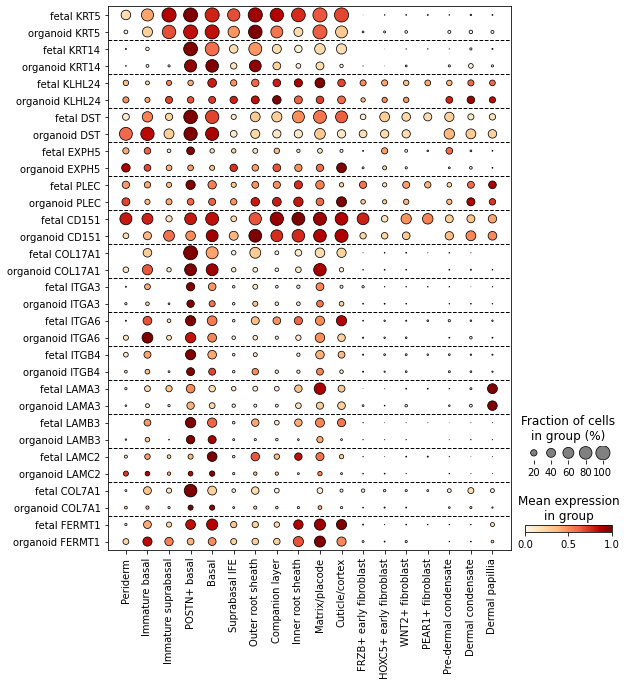

In [64]:
sk.set_figsize((8, 10))

# Main axes
ax = sn.scatterplot(
    data=df,
    x="x",
    y="y",
    hue="mean2",
    size="frac",
    palette="OrRd",
    edgecolor="k",
    sizes=(0, 200),
    legend=False,
)
ax.set_xticks(np.arange(df.annot.cat.categories.size))
ax.set_xticklabels(df.annot.cat.categories, rotation=90)
ax.set_yticks(np.arange(df.gene2.cat.categories.size))
ax.set_yticklabels(df.gene2.cat.categories)
ax.set_ylim(df.gene2.cat.categories.size - 0.5, -0.5)
for ypos in [i - 0.5 for i in range(df.gene2.cat.categories.size) if i > 0 and i % 2 == 0]:
    ax.axhline(y=ypos, linewidth=1, c="k", linestyle="--")
ax.set_xlabel("")
ax.set_ylabel("")

# Make legend
fig = ax.get_figure()
main_width = 0.825
gap_width = 0.025
fig.subplots_adjust(right=main_width)

# Dot size legend
dlg_ax = fig.add_axes([main_width + gap_width, 0.25, 1 - main_width - gap_width, 0.02])
sn.scatterplot(
    x=[20, 40, 60, 80, 100],
    y=[0, 0, 0, 0, 0],
    size=[20, 40, 60, 80, 100],
    sizes=(40, 200),
    color=[(0.5, 0.5, 0.5)],
    edgecolor="black",
    ax=dlg_ax,
    legend=False,
)
sn.despine(ax=dlg_ax, left=True, bottom=True)
dlg_ax.get_yaxis().set_visible(False)
dlg_ax.set_xticks([20, 40, 60, 80, 100])
dlg_ax.set_xlim(10, 110)
dlg_ax.set_title("Fraction of cells\nin group (%)")

# Colorbar
cb_ax = fig.add_axes([main_width + gap_width, 0.15, 1 - main_width - gap_width, 0.01])
cb_ax.set_title("Mean expression\nin group")
fig.colorbar(
    plt.cm.ScalarMappable(
        cmap="OrRd",
    ),
    cax=cb_ax,
    orientation="horizontal",
)
sn.despine(ax=cb_ax, left=True, bottom=True)
cb_ax.get_yaxis().set_visible(False)

In [65]:
fig.savefig("figures/figS2L.20221010.pdf", bbox_inches="tight")

In [66]:
!rclone copy --drive-shared-with-me figures/figS2L.20221010.pdf "google:/Fetal Skin/Figures/Figs_from_Ni/"